In [1]:
import torch
import pandas as pd
import numpy as np

from training_utils.file_utils import open_json, log_kfold_training, save_submission
from training_utils.model_utils import (load_dataset, split_dataset,
                                        load_models_and_scalers, save_models_and_scalers)
from custom_thermonet.training import k_fold_training


In [7]:
NAME = "all_v3/"
DATASET_DIR = "../data/main_dataset_creation/outputs/"+NAME
LOG_NAME = "Thermonet"
KEEP_MODELS = True
SIMPLE_TRAIN = True
COMPUTE_SUBMISSION = True


In [3]:
config = open_json("thermonet_config.json")
features = ["direct_voxel_features"]

In [4]:
if torch.cuda.is_available() and config["use_cuda"]:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(device)


cuda


### Training

training on 4224 data
training on 4224 destabilizing mutation only


100%|██████████| 5/5 [01:29<00:00, 17.97s/it]


logged training in ./outputs/Thermonet_6


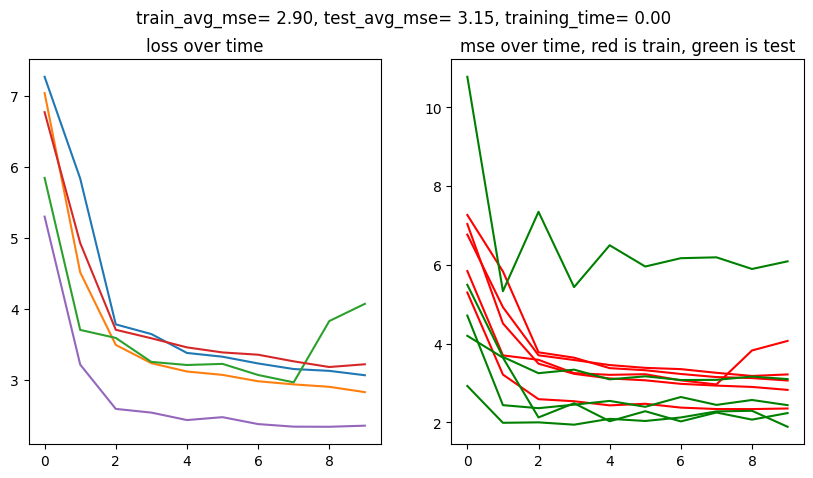

In [5]:
if SIMPLE_TRAIN:
    df = load_dataset(config, features)

    df["direct_voxel_path"] = df["direct_voxel_path"].apply(
        lambda row: row.replace("./",
                                "../compute_mutated_structures/")+".npy")
    df["direct_voxel_features"] = df["direct_voxel_path"].apply(np.load)

    all_training_results = {"simple_train": [],
                            "total_training_time": 0}

    # add protein_index to the dataset and get ksplit:
    df = split_dataset(df, config)
    training_results, model_list = k_fold_training(
        df, config, features, device, keep_models=KEEP_MODELS)
        
    all_training_results = {}
    # add training results to all the other ones
    all_training_results["simple_train"] = training_results


    # save results to output
    dir_path = log_kfold_training(LOG_NAME, all_training_results,
                    config, features, "Thermonet")
    if KEEP_MODELS:
        save_models_and_scalers(dir_path, model_list, [])
    print(f"logged training in {dir_path}")


### Predicting on Submission dataset

In [8]:
if COMPUTE_SUBMISSION:
    dir_path = "outputs/Thermonet_6/"
    df_test = pd.read_csv(
        f"{config['dataset_dir']}/submission_with_voxel.csv")

    # fill na with random voxel:
    df_test["direct_voxel_path"].fillna(df_test["direct_voxel_path"][0], inplace=True)
    # load voxel directly in df
    df_test["direct_voxel_path"] = df_test["direct_voxel_path"].apply(
        lambda row: row.replace("./",
                                "../compute_mutated_structures/")+".npy")
    df_test["direct_voxel_features"] = df_test["direct_voxel_path"].apply(
        np.load)
    results = []

    model_list, _ = load_models_and_scalers(dir_path)

    for k in range(len(model_list)):
        X_test = df_test[features].copy()

        model = model_list[k]  # model result from the training

        # Evaluate this model:
        model.eval()
        with torch.set_grad_enabled(False):
            X_test = X_test.to_numpy()

            X_test = torch.stack([torch.as_tensor(x, dtype=torch.float)
                                  for x in X_test[:, 0]])
            X_test = X_test.to(device)
            y_test = model(X_test)
            results.append(y_test.cpu().detach().numpy())

    submission = pd.DataFrame(columns=["seq_id", "tm"])
    submission["seq_id"] = df_test["seq_id"]
    submission["tm"] = np.mean(np.array(results), axis=0)
    print(submission.head())
    save_path = save_submission(submission, LOG_NAME)
    print(f"{save_path=}")


   seq_id        tm
0   31390 -1.641925
1   31391 -1.357702
2   31392 -1.912118
3   31393 -1.616124
4   31394 -1.536806
save_path='./submissions/Thermonet_2022-11-29_11-22-05.csv'
